## Introduction

### Group members

* Khater, Yara
* Castillo, Galo
* Guaranda, María Belén

In [3]:
import re
from pathlib import Path

import gensim
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import wordcloud
from sklearn import (
    decomposition,
    ensemble,
    feature_extraction,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
)
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from collections import Counter
import time
from lightgbm import LGBMClassifier
import transformers
from transformers import BertModel, BertTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
sns.set_style("darkgrid")
sns.set_context("notebook")

tqdm.pandas()

%config InlineBackend.figure_format="retina"  # For high DPI display
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

In [44]:
DATA = Path("archive")

assert DATA.is_dir()

IMG = Path("img")

assert IMG.is_dir()

In [45]:
df = pd.read_csv(DATA / "Reviews_small.csv.xz")
df.head()

,Unnamed: 0,Score,Summary,Text
0,0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,4,5,Great taffy,Great taffy at a great price. There was a wid...


* Contains some product, user, and review information

* Data used here:

    * Text: Complete product review by the customer
    * Summary: Summary proposed by the customer
    * Score: The product rating provided by the customer

In [46]:
num_entries = df.shape[0]
nulls_summary = df["Summary"].isnull().sum()
nulls_text = df["Text"].isnull().sum()

print("There are %9d entries in our dataset.\nThere are %3d null values for the Summary column, and %2d null values for the Text column." % (num_entries, nulls_summary, nulls_text))

There are    394970 entries in our dataset.
There are   3 null values for the Summary column, and  0 null values for the Text column.


In [47]:
# Checking if there are duplicated rows (taking into account all the columns)
print("There are %d duplicated rows" % df.duplicated().sum())

#Now check duplicates of texts
print("There are %d duplicated texts." % df.duplicated(subset=["Summary","Text"]).sum())

There are 0 duplicated rows
There are 0 duplicated texts.


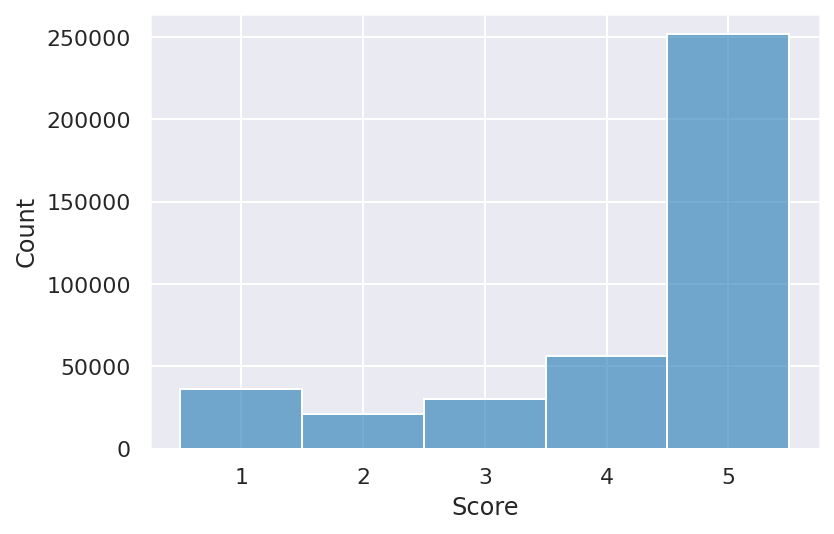

In [48]:
sns.histplot(df, x="Score", alpha=0.6, discrete=True)
plt.show()

### Analysis 3-classes versions

In [49]:
def convert_rating(rating, threshold=3):
    if rating > threshold:
        return 1
    if rating < threshold:
        return -1
    return 0

In [50]:
df["sentiment"] = df.Score.map(convert_rating)

This is the new distribution of the target variable sentiment

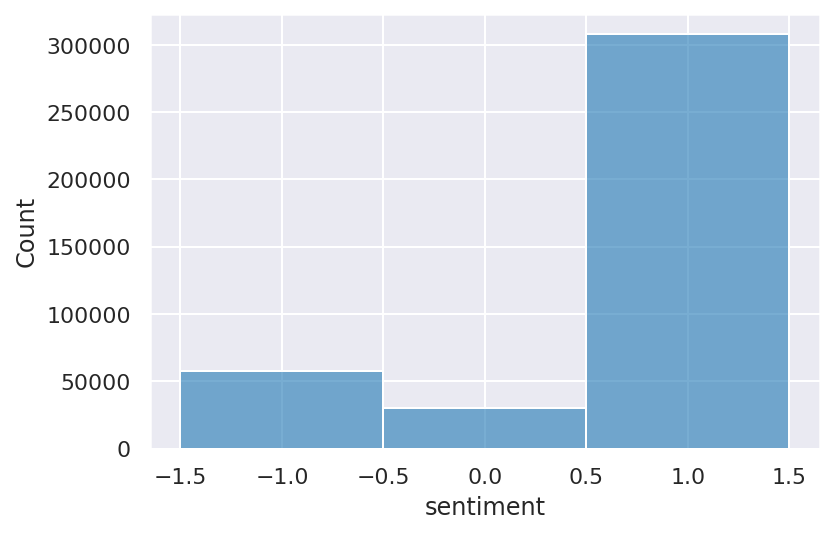

In [51]:
sns.histplot(df, x="sentiment", alpha=0.6, discrete=True)
plt.show()

In [52]:
df.describe()

,Unnamed: 0,Score,sentiment
count,394970.000000,394970.000000,394970.000000
mean,261543.868960,4.178659,0.634076
std,167039.910688,1.312818,0.722777
min,0.000000,1.000000,-1.000000
25%,112825.250000,4.000000,1.000000
50%,248987.500000,5.000000,1.000000
75%,407288.750000,5.000000,1.000000
max,568453.000000,5.000000,1.000000


### Words distribution

In [54]:
# Create stopword list
diff_stopwords = set(wordcloud.STOPWORDS) ^ set(
    nltk.corpus.stopwords.words("english")
)
print(len(diff_stopwords))

stopwords = set(wordcloud.STOPWORDS) | set(
    nltk.corpus.stopwords.words("english")
)
stopwords.update(["br", "href"])
print(len(stopwords))

83
229


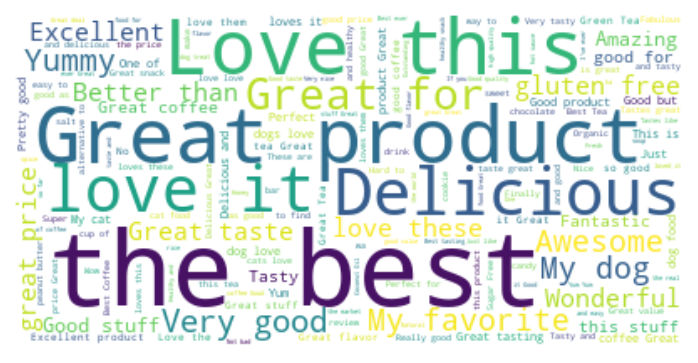

In [55]:
positive_df = df[df.sentiment == 1]

pos_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(positive_df.Summary.dropna()))

plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(IMG / "pos_wordcloud.png")
plt.show()

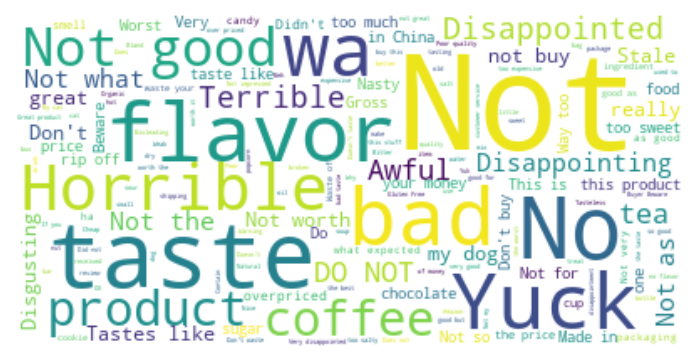

In [56]:
negative_df = df[df.sentiment == -1]

neg_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(negative_df.Summary.dropna()))

plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(IMG / "neg_wordcloud.png")
plt.show()

* Positive sentiment words, e.g., *love, best, delicious*

* Negative sentiment words, e.g., *disappointed, bad, yuck*

* The word ***good*** appears in the negative sentiment word cloud, despite being a positive word 

    * Probably because it was used in a negative context: ***not good*** 

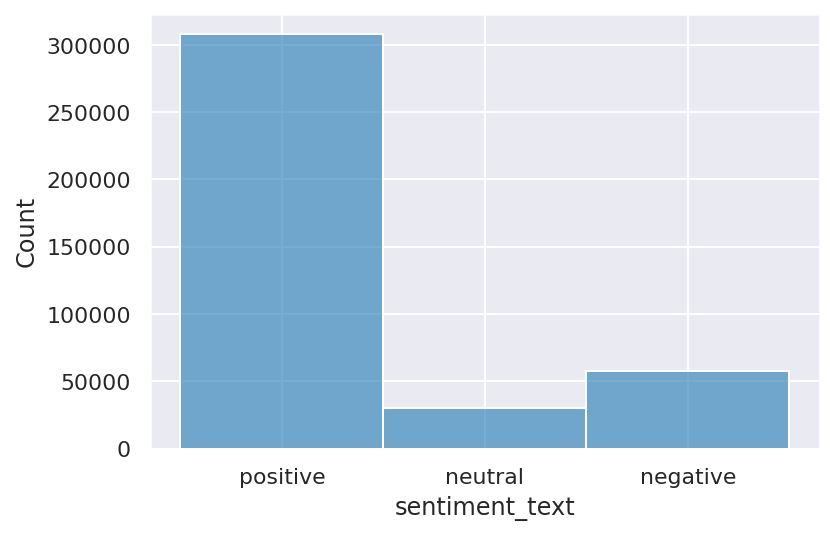

In [57]:
df["sentiment_text"] = (
    df.sentiment.replace({-1: "negative", 0: "neutral", 1: "positive"})
    .astype("category")  # To set the x-axis order in sns.histplot
    .cat.reorder_categories(["positive", "neutral", "negative"])
)

sns.histplot(
    df,
    x="sentiment_text",
    alpha=0.6,
    discrete=True,
)
plt.show()

## Create the train and test sets

In [58]:
train_df, test_df = model_selection.train_test_split(
    df, test_size=0.2, random_state=1
)

# BERT embeddings

In [ ]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

Check how the tokenizer works:

In [ ]:
sample_txt = df.iloc[0]["Text"]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
   Tokens: ['I', 'have', 'bought', 'several', 'of', 'the', 'Vita', '##lity', 'can', '##ned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', '.', 'The', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', '.', 'My', 'Labrador', 'is', 'fin', '##ick', '##y', 'and', 'she', 'appreciate', '##s', 'this', 'product', 'better', 'than', 'most', '.']
Token IDs: [146, 1138, 3306, 1317, 1104, 1103, 25118, 11796, 1169, 3540, 3676, 2094, 2982, 1105, 1138, 1276, 1172, 1155, 1106, 1129, 1104, 1363, 3068, 119, 1109, 3317, 2736, 1167, 1176, 170, 26036, 1190, 170, 14659, 6092, 1105, 1122, 16533, 1618, 119, 1422, 20255,

**Tokenizing with Bert tokenizer the whole dataframe**

Input ids and attention masks have size [1,150]

In [ ]:
def fastTokenizerBert(row):
    encoding = tokenizer.encode_plus(row["Text"],
                                     max_length=150, #number of tokens and attention mask elements
                                     padding="max_length",
                                     truncation=True,
                                     return_tensors="pt")
    row["input_ids"] = encoding["input_ids"]
    row["attention_mask"] = encoding["attention_mask"]
    return row

In [ ]:
new_train_df = test_df.apply(fastTokenizerBert, axis=1)
new_test_df = train_df.apply(fastTokenizerBert, axis=1)

In [ ]:
new_train_df.head(2)

,Unnamed: 0,Score,Summary,Text,sentiment,sentiment_text,input_ids,attention_mask
115375,133520,5,Hooray for Gooseberries!!!,Tried for a few years to obtain gooseberries b...,1,positive,"[[tensor(101), tensor(18491), tensor(1174), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
290549,398096,4,"Really good, and with modifications....","If it's curry, chances are pretty great that I...",1,positive,"[[tensor(101), tensor(1409), tensor(1122), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [ ]:
# Instantiate model and move it to the GPU
model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Create tensor dataset and move to GPU**

In [ ]:
train_inputs_tensors = torch.concat(list(new_train_df["input_ids"].values))
train_masks_tensors = torch.concat(list(new_train_df["attention_mask"].values))

test_inputs_tensors = torch.concat(list(new_test_df["input_ids"].values))
test_masks_tensors = torch.concat(list(new_test_df["attention_mask"].values))

In [ ]:
# Convert to tensor dataset
# DataLoaders gives an iterator
train_data = TensorDataset(train_inputs_tensors, train_masks_tensors)
train_dataloader = DataLoader(train_data, batch_size=16)

test_data = TensorDataset(test_inputs_tensors, test_masks_tensors)
test_dataloader = DataLoader(test_data, batch_size=32)

**Bert embeddings for train set**

In [ ]:
bert_features_arr = []
start_time = time.time()
for batch in train_dataloader:
  # Send data to GPU
  input_ids_gpu = batch[0].to(device)
  attention_mask_gpu = batch[1].to(device)
  # Model returns object with keys
  model_output = model(
    input_ids = input_ids_gpu,
    attention_mask = attention_mask_gpu
  )
  bert_ft_batch = model_output.last_hidden_state[:, 0, :].cpu().detach().numpy()
  bert_features_arr.append(bert_ft_batch)

runtime = time.time()-start_time
print("Model trained in %s seconds" % (runtime))

Model trained in 1914.7494320869446 seconds
